Generate intial word embedding for headlines and description

The embedding is limited to a fixed vocabulary size (`vocab_size`) but
a vocabulary of all the words that appeared in the data is built.

Create data directory in the repository and:
- download news and decompres gz file there,
- download glove data files and unzip there.

In [101]:
from tqdm.notebook import trange, tqdm
import pickle
import json

In [1]:
FN = 'vocabulary-embedding'

In [2]:
seed=42

In [3]:
vocab_size = 40000

In [4]:
embedding_dim = 100

In [5]:
lower = False # dont lower case the text

# Prepare heads, desc data from downloaded dataset

In [18]:
fndata = './data/signalmedia-1m.jsonl'
num_articles = 20000

In [102]:

heads = []
desc = []
keywords = []
counter = 0
with open(fndata) as f:
        for line in tqdm(f):
            if counter < num_articles:
                jdata = json.loads(line)
                heads.append(jdata["title"].lower())
                desc.append(jdata["content"].lower())
                keywords.append(None)
                counter +=1
            else:
                break

In [20]:
FN0 = 'tokens' # this is the name of the data file

In [21]:
import pickle
with open('data/%s.pkl'%FN0, 'wb') as f:
    pickle.dump((heads, desc, keywords), f)

# read tokenized headlines and descriptions

In [23]:
with open('data/%s.pkl'%FN0, 'rb') as fp:
    heads, desc, keywords = pickle.load(fp) # keywords are not used in this project

In [24]:
if lower:
    heads = [h.lower() for h in heads]

In [25]:
if lower:
    desc = [h.lower() for h in desc]

In [26]:
i=0
heads[i]

'worcester breakfast club for veterans gives hunger its marching orders'

In [27]:
desc[i]

'veterans saluted worcester\'s first ever breakfast club for ex-soldiers which won over hearts, minds and bellies. \n \nthe worcester breakfast club for hm forces veterans met at the postal order in foregate street at 10am on saturday. \n \nthe club is designed to allow veterans a place to meet, socialise, eat and drink, giving hunger and loneliness their marching orders. \n \nfather-of-two dave carney, aged 43, of merrimans hill, worcester, set up the club after being inspired by other similar clubs across the country. \n \nhe said: "as you can see from the picture, we had a good response. five out of the 10 that attended said they saw the article in the newspaper and turned up. \n \n"we even had an old chap travel from droitwich and he was late on parade by three hours. \n \n"it\'s generated a lot of interest and i estimate (from other veterans who saw the article) that next month\'s meeting will attract about 20 people. onwards and upwards." \n \nhe said the management at the pub ha

In [28]:
keywords[i]

In [29]:
len(heads),len(set(heads))

(20000, 19783)

In [30]:
len(desc),len(set(desc))

(20000, 19700)

# build vocabulary

In [44]:
from collections import Counter
from itertools import chain
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return vocab, vocabcount

In [79]:
vocab, vocabcount = get_vocab(heads+desc)

most popular tokens

In [80]:
vocab = list(vocab)
print(vocab[:50])
print(len(vocab))

['the', 'and', 'to', 'of', 'a', 'in', 'for', 'is', 'on', 'that', 'with', 'at', 'as', 'was', 'by', 'it', 'be', 'are', 'from', 'this', 'have', 'will', 'has', 'he', 'i', 'an', 'you', 'or', 'but', 'his', 'not', 'their', 'we', 'more', 'they', '-', 'new', 'about', 'said', 'all', 'who', 'can', 'which', 'its', 'our', 'one', 'been', 'your', 'also', 'had']
399670


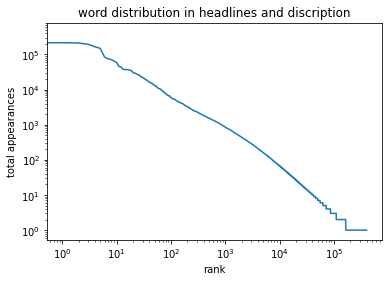

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonpositive='clip')
plt.gca().set_yscale("log", nonpositive='clip')
plt.title('word distribution in headlines and discription')
plt.xlabel('rank')
plt.ylabel('total appearances');

always nice to see [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)

# Index words

In [82]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

In [83]:
def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

In [84]:
word2idx, idx2word = get_idx(vocab, vocabcount)

# Word Embedding

## read GloVe

In [85]:
fname = 'glove.6B.%dd.txt'%embedding_dim
fname

'glove.6B.100d.txt'

In [86]:
import os
datadir = './'
# datadir_base = os.path.expanduser(os.path.join('~', '.keras'))
# if not os.access(datadir_base, os.W_OK):
#     datadir_base = os.path.join('/tmp', '.keras')
# datadir = os.path.join(datadir_base, 'datasets')
glove_name = os.path.join(datadir, fname)
# if not os.path.exists(glove_name):
#     path = 'glove.6B.zip'
#     path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
#     !unzip {datadir}/{path}

In [87]:
glove_n_symbols = !wc -l {glove_name}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
glove_n_symbols

400000

In [103]:
# use LRU
import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(glove_name, 'r') as fp:
    i = 0
    for l in tqdm(fp):
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

In [89]:
glove_embedding_weights.std()

0.04081572760019029

In [104]:
for w,i in tqdm(glove_index_dict.items()):
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

## embedding matrix

use GloVe to initialize embedding matrix

In [91]:
# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in trange(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04081382495746382
number of tokens, in small vocab, found in glove and copied to embedding 25695 0.642375


lots of word in the full vocabulary (word2idx) are outside `vocab_size`.
Build an alterantive which will map them to their closest match in glove but only if the match
is good enough (cos distance above `glove_thr`)

In [92]:
glove_thr = 0.5

In [97]:
word2glove = {}
for w in tqdm(word2idx):
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

for every word outside the embedding matrix find the closest word inside the mebedding matrix.
Use cos distance of GloVe vectors.

Allow for the last `nb_unknown_words` words inside the embedding matrix to be considered to be outside.
Dont accept distances below `glove_thr`

In [105]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in tqdm(word2idx.items()):
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))


# of glove substitutes found 45270


manually check that the worst substitutions we are going to do are good enough

In [107]:
for orig, sub, score in glove_match[-10:]:
    print(score, orig,'=>', idx2word[sub])

0.5000343628037485 potshot => dianabol
0.500029707252299 felonious => indecent
0.5000234871023845 tagil => crivitz
0.5000229620201357 perversions => femininity
0.5000196524388687 montag => seager
0.500019190694808 codefendant => 55-year-old
0.5000175899815114 trapezium => ganpati
0.5000046854399101 reoffend => 2014/15
0.5000037989997332 maia => joanna
0.5000035538790735 jammy => fruity


build a lookup table of index of outside words to index of inside words

In [108]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)

# Data

In [109]:
Y = [[word2idx[token] for token in headline.split()] for headline in heads]
len(Y)

20000

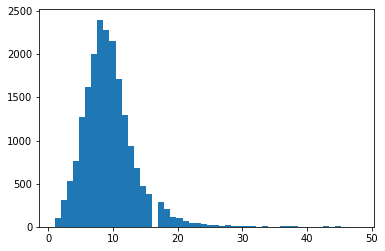

In [111]:
plt.hist(list(map(len,Y)),bins=50);

In [112]:
X = [[word2idx[token] for token in d.split()] for d in desc]
len(X)

20000

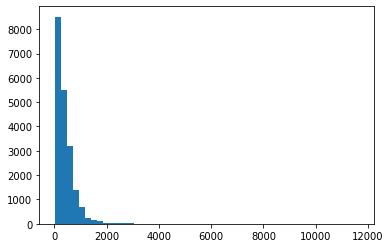

In [113]:
plt.hist(list(map(len,X)),bins=50);

In [114]:
import pickle
with open('data/%s.pkl'%FN,'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [115]:
with open('data/%s.data.pkl'%FN,'wb') as fp:
    pickle.dump((X,Y),fp,-1)